# **Entregable:** Calibración de modelo de serie de tiempo para realizar predicción
##  Cutberto Arizabalo Nava A01411431



In [1]:
from google.colab import drive
drive.mount("/content/gdrive")  

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/MyDrive/IA95022"
%ls

/content/gdrive/MyDrive/IA95022
 bezdekIris.data              notebookdc8e90834b.ipynb
 class_060922_starter.ipynb  'Store Sales'/
 DryBeanDataset/              train.csv
 Index                        tutorial_checkpoints/
 Indicadores.csv              tutorial_checkpoints_best/
 Indicadores.xlsx             us2022q2a.csv
 iris.data                    usfirms2022.csv
 iris.names                   Wine/
'Modulo 4'/


# Carga y visualización de dataset

In [65]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import plotly.express as px
from matplotlib.pyplot import xlabel

In [66]:
df = pd.read_csv('Indicadores.csv')

In [67]:
df = df.sort_values(by='Periodo').reset_index(drop=True)

In [68]:
df

,Periodo,Valor
0,1993/01,60.407691
1,1993/02,61.022521
2,1993/03,63.943249
3,1993/04,61.865984
4,1993/05,63.612900
...,...,...
350,2022/03,111.940152
351,2022/04,109.529866
352,2022/05,114.442424
353,2022/06,112.797501


In [ ]:
px.line(x = df["Periodo"], y = df["Valor"] , labels = {"x":"Periodo","y":"Valor"} , title="ÍNDICE GLOBAL DE ACTIVIDAD ECONÓMICA (MÉXICO) " )

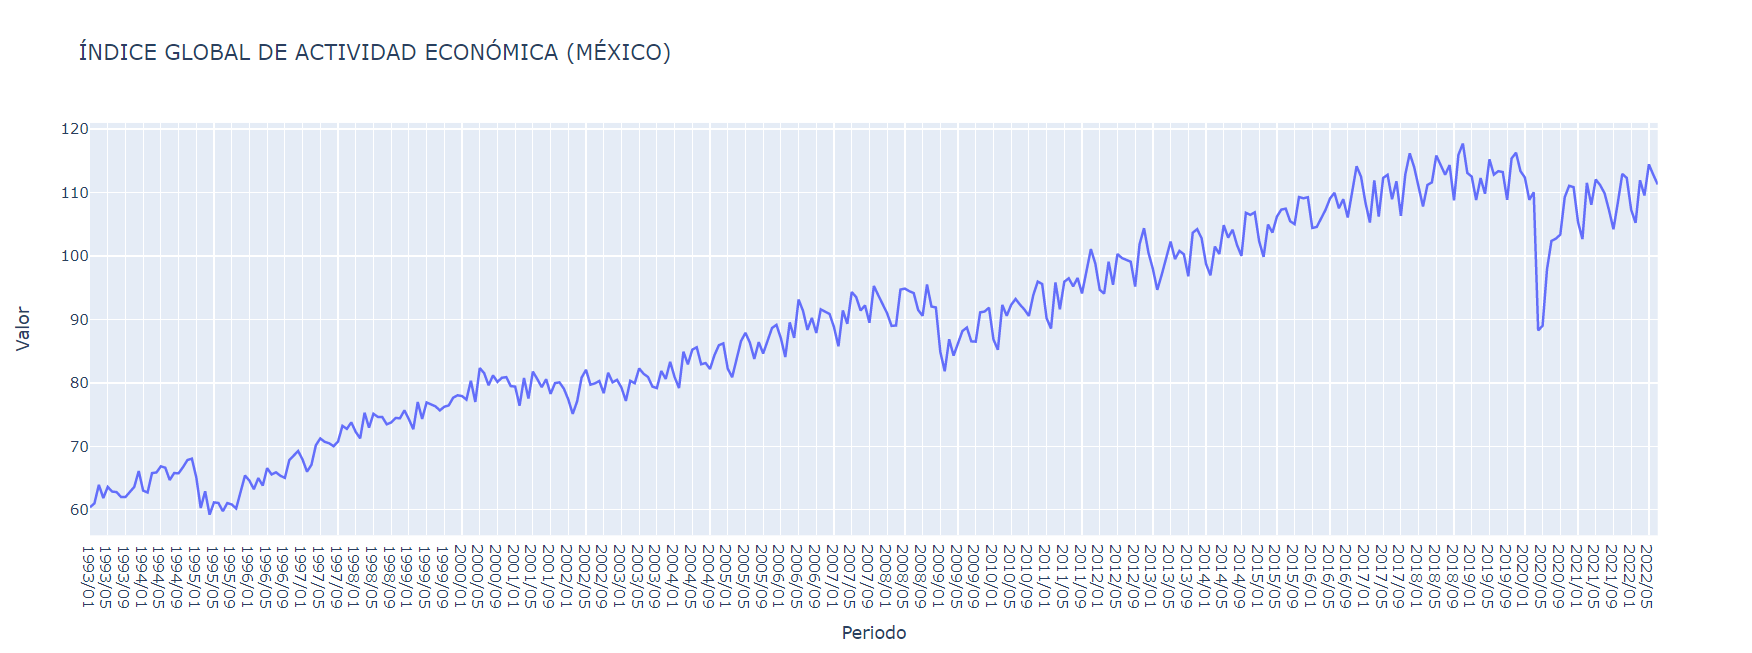

# Revisión de estacionaridad de la variable


La prueba de Dicky-Fueller nos permite conocer si una variable es estacionaria o no. Por lo tanto, aprovecharemos este test para conocer dicha propiedad de nuestra variable.

In [70]:
df['ln(Valor)'] = np.log(df['Valor'])

In [71]:
print(adfuller(df['ln(Valor)'])[1])

0.6692238553809415


La prueba nos arroja un p-value de 0.66. 
Para poder afirmar que una variable es estacionaria, necesitamos un p-value igual o inferior a 0.05, y en este caso tenemos un valor que se aleja considerablemente de este margen de toleracia. 

Por lo tanto, podemos afirmar que nuestra variable no es estacionaria. 

Para convertir en estacionaria nuestra variable, probaremos ajustando los parámetros de D y d. 

Como prueba inicial se configurará un valor D=1 y d=0, esto se traduce en considerar el cambio anual de la variable, lo cual nos da una mayor capacidad de predicción en comparación a utilizar el cambio mensual.

In [72]:
df['First_diff']= df['ln(Valor)']  - np.log(df['Valor']).shift(1)
df['Anual_diff']= df['ln(Valor)']  - np.log(df['Valor']).shift(12)
df

,Periodo,Valor,ln(Valor),First_diff,Anual_diff
0,1993/01,60.407691,4.101116,NaN,NaN
1,1993/02,61.022521,4.111243,0.010127,NaN
2,1993/03,63.943249,4.157996,0.046753,NaN
3,1993/04,61.865984,4.124970,-0.033025,NaN
4,1993/05,63.612900,4.152816,0.027846,NaN
...,...,...,...,...,...
350,2022/03,111.940152,4.717964,0.061805,0.003661
351,2022/04,109.529866,4.696197,-0.021767,0.013414
352,2022/05,114.442424,4.740072,0.043875,0.021001
353,2022/06,112.797501,4.725594,-0.014478,0.014522


In [73]:
print(adfuller(df['Anual_diff'].dropna())[1])

0.0032602635598127376


En esta ocasión hallamos un p-value que es inferior a 0.05, por lo que tenemos una muy alta certeza de que nuestra variable se vuelve estacionaria cuando utilizamos valores de D = 1 y d = 0 

# Revisión de niveles de autocorrelación

La autocorrelación se refiere a la forma en que una variable se relaciona consigo misma, específicamente con sus valores en periodos anteriores. 

En este caso, graficaremos la autocorrelación parcial para ver si existe una relación directa con los valores que la variable toma en sus lags anteriores.

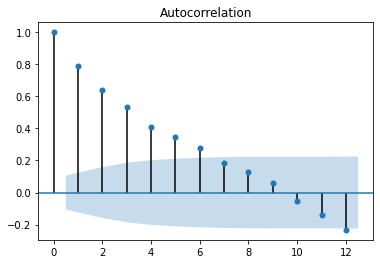

In [74]:
plot = plot_acf(df['Anual_diff'].dropna(), lags = 12)

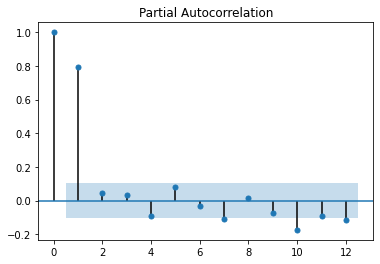

In [55]:
plot = plot_pacf(df['Anual_diff'].dropna(), lags = 12)

Al revisar las gráficas de autocorrelación y autocorrelación parcial, es posible identificar un patrón muy claro: 
En la ACP hay un decrecimiento gradual del valor, mientras que en la PACP observamos únicamente una correlación estadísticamente significativa en el primer lag.

Debido al patrón observado, se asignarán valores de q = 0 y p = 1

# Modelación con SARIMA

In [75]:
d = 0 
D = 1
P = 0
Q = 0
p = 1
q = 0

In [77]:
modelo = sm.tsa.statespace.SARIMAX(df['ln(Valor)'], order=(p,d,q), seasonal_order = (P,D,Q,12), trend='c',  simple_differencing=True)

In [78]:
modelo_fit = modelo.fit(disp = 0)

In [79]:
print(modelo_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     DS12.ln(Valor)   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 741.706
Date:                            Tue, 25 Oct 2022   AIC                          -1477.413
Time:                                    00:18:20   BIC                          -1465.899
Sample:                                         0   HQIC                         -1472.827
                                            - 343                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.741      0.006       0.001       0.007
ar.L1          0.7905      0.021   

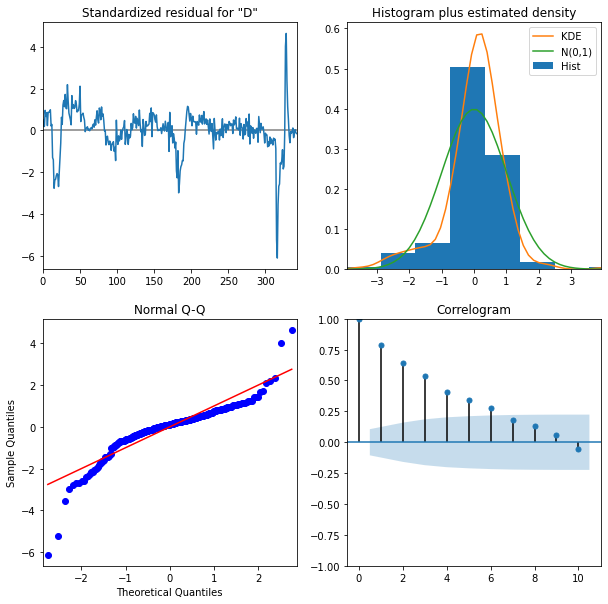

In [63]:
plot = modelo_fit.plot_diagnostics(figsize=(10,10))

Finalmente, el modelo está listo. De acuerdo al resultado que nos brinda el framework, vemos que el coeficiente otorgado al L1 tiene una alta magnitud, además de tener alta significancia estadística debido a su z-value.

Para validar si nuestro modelo requiere alguna calibración adicional es necesario revisar el comportamiento de los residuos. 

Lo que buscamos conseguir es un comportamiento de "White noise", es decir, que estos residuos sean solamente ruido de fondo, valores que ya no guardan alguna correlación entre sí. 

Para averiguar si los errores son ruido blanco, analizaremos sus ACF y PACF.

In [80]:
residuos = modelo_fit.resid

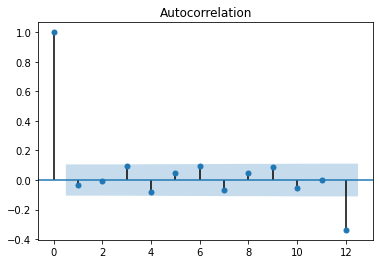

In [83]:
plot = plot_acf(residuos, lags = 12)

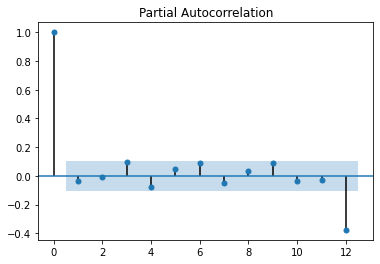

In [84]:
plot = plot_pacf(residuos, lags = 12)

Ignorando el lag 0 (ya que es el mismo valor), hallamos una correlación alta en el lag 12. Esto nos indica que aún no tenemos un comportamiento de white noise, por lo que haremos una modificaicón a nuestro modelo. 

Al observar una auto correlación anual residual, podemos asignar Q = 1 y volver a validar el modelo.

# Calibración del modelo

In [87]:
d = 0 
D = 1
P = 0
Q = 1
p = 1
q = 0

In [88]:
modelo = sm.tsa.statespace.SARIMAX(df['ln(Valor)'], order=(p,d,q), seasonal_order = (P,D,Q,12), trend='c',  simple_differencing=True)

In [89]:
modelo_fit = modelo.fit()

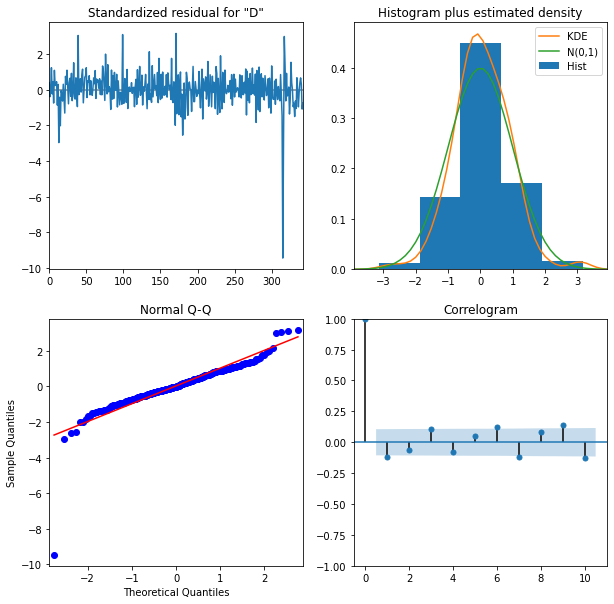

In [90]:
plot = modelo_fit.plot_diagnostics(figsize=(10,10))

In [91]:
print(modelo_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       DS12.ln(Valor)   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 805.821
Date:                              Tue, 25 Oct 2022   AIC                          -1603.642
Time:                                      00:26:30   BIC                          -1588.291
Sample:                                           0   HQIC                         -1597.528
                                              - 343                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.000      6.274      0.000       0.002       0.003
ar.L1          0.87

Vemos que nuestro modelo presenta características muy similares a las que tenía previamente, pero con diferencias en los valores de cada magnitud. 
En el caso del lag 1, vemos que hay una alta magnitud y una relación positiva, además de ser el valor que tiene mayor significacia estadística debido al z value. 
Hablando del lag 12, se observa una alta magnitud con una relación negativa. Este coeficiente también es significativo estadísticamente, lo cual se observa directamente en su z value.

Ahora repetiremos el proceso de validación para averiguar si ya obtuvimos ruido blanco en los residuos

In [92]:
residuos = modelo_fit.resid

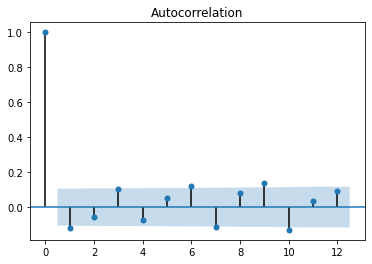

In [94]:
plot = plot_acf(residuos, lags = 12)

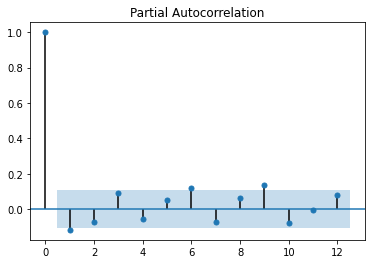

In [95]:
plot = plot_pacf(residuos, lags = 12)

Podemos ver que después de la calibración obtuvimos un modelo cuyos residuos no presentan alguna correlación fuerte o altamente significativa, por lo que logramos acercarnos al comportamiento deseado de ruido blanco.
Si bien se observan algunas correlaciones ligeramente encima del margen de significancia, obtuvimos una mejora bastante considerable con respecto al comportamiento del ruido en el primer modelo.

# Predicción con el modelo

Ahora vamos a crear predicciones utilizando nuestro modelo entrenado. 

Para estas predicciones, crearemos un nuevo dataframe que contenga unicamente los valores del predict, para posteriormente fusionarlo con el original y poder visualizar tanto los valores reales como los pronosticados

In [148]:
import numpy as np
modelo = sm.tsa.statespace.SARIMAX(df['Valor'], order=(p,d,q), seasonal_order = (P,D,Q,12), trend='c',  simple_differencing=False)
modelo_fit = modelo.fit()
predicciones  = np.asarray((modelo_fit.forecast(steps=24)))
forecast= pd.DataFrame()
forecast["Periodo"] = np.asarray(["2022/08","2022/09","2022/10","2022/11",
                       "2022/12","2023/01","2023/02","2023/03",
                       "2023/04","2023/05","2023/06","2023/07",
                       "2023/08","2023/09","2023/10","2023/11",
                       "2023/12","2024/01","2024/02","2024/03",
                       "2024/04","2024/05","2024/06","2024/07"])
forecast["Predict"] = predicciones


In [149]:
#dataframe de la predicción
forecast

,Periodo,Predict
0,2022/08,111.619278
1,2022/09,109.389604
2,2022/10,115.252017
3,2022/11,117.661370
4,2022/12,116.502626
5,2023/01,113.113506
6,2023/02,110.762342
7,2023/03,115.892249
8,2023/04,111.611682
9,2023/05,115.482149


In [154]:
#fusionamos ambos dataframes
final_df = pd.concat([df, forecast])
final_df = final_df.set_index("Periodo", drop = True)
final_df = final_df[["Valor", "Predict"]]


Finalmente, podemos visualizar los resultados de la predicción, la cual respeta la tendencia a la alza de los valores, así como el comportamiento característico observable en los periodos anteriores.

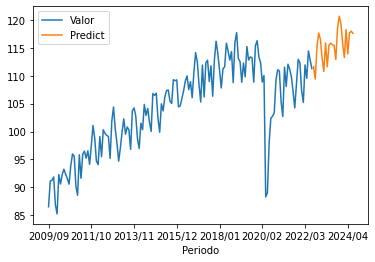

In [159]:
final_df[200:].plot()